# Weather Data Analysis with a public API

In [1]:
import grequests as asynhttp #Peticiones asincronas
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib

### Data Collection and Cleaning

In [2]:
capitales = {
    "Africa": ["El Cairo", "Abuya", "Nairobi", "Addis Abeba", "Pretoria"],
    "America": ["Washington D. C.", "Ottawa", "Ciudad de México", "Brasilia", "Buenos Aires",],
    "Asia": ["Pekín", "Tokio", "Nueva Delhi", "Seúl", "Riad"],
    "Europa": ["Madrid", "París", "Berlín", "Roma", "Londres"],
    "Oceania": ["Canberra", "Wellington", "Port Moresby", "Suva", "Apia"],
}
key="030c86ad50fe0b9ad9817deeb4fc2825"

Usamos la API geo de OpenWeather para obtener la latitud y longitud de cada ciudad por su nombre, y construimos un dataframe. 

In [3]:
localizaciones={
    "continente": [],
    "name": [],
    "lat": [],
    "lon": []
}

rs=[]
for continente in capitales:
    for ciudad in capitales[continente]:
        url=f"http://api.openweathermap.org/geo/1.0/direct?q={ciudad}&appid={key}"
        rs.append(asynhttp.get(url))
        localizaciones["continente"].append(continente)
        
futures = asynhttp.map(rs)
for futuro in futures:
    response=futuro.json()    
    localizaciones["name"].append(response[0]["name"])
    localizaciones["lat"].append(response[0]["lat"])
    localizaciones["lon"].append(response[0]["lon"])

In [4]:
df_localizaciones=pd.DataFrame(localizaciones).set_index("name")
df_localizaciones

,continente,lat,lon
name,,,
Cairo,Africa,30.044388,31.235726
Abuja,Africa,9.064331,7.489297
Nairobi,Africa,-1.303264,36.826384
Addis Ababa,Africa,9.010793,38.761252
Pretoria,Africa,-25.745928,28.187910
Washington,America,38.895037,-77.036543
Ottawa,America,45.420878,-75.690111
Mexico City,America,19.432630,-99.133178
Brasília,America,-15.793404,-47.882317


Ahora usamos la API en tiempo real de OpenWeather para obtener el tiempo de cada ciudad. Una vez tenemos todas las respuestas **procesamos el json** para formar un dataframe con la información que nos interesa. 

In [5]:
rs=[]
for entrada in df_localizaciones.values:
    url=f"https://api.openweathermap.org/data/2.5/weather?lat={entrada[1]}&lon={entrada[2]}&appid={key}&units=metric&lang=sp"
    rs.append(asynhttp.get(url))

tiempo=[]
futures = asynhttp.map(rs)
for futuro in futures:
    tiempo.append(json.loads(futuro.text))

In [6]:
for ciudad in tiempo:
    for i, e in enumerate(ciudad["weather"]):
        del ciudad["weather"][i]["id"]
        del ciudad["weather"][i]["icon"]

In [7]:
df_tiempo = pd.json_normalize(tiempo, "weather", [["main", "temp"], ["main", "feels_like"],
    ["main", "temp_min"],["main", "temp_max"],["main", "pressure"],["main", "humidity"],
    ["main", "sea_level"],["main", "grnd_level"], "visibility", ["wind", "speed"], ["wind", "deg"], 
    ["wind", "gust"], ["rain", "1h"], ["snow", "1h"], ["clouds", "all"], "dt"], sep="-", errors="ignore")

In [8]:
df_tiempo = df_localizaciones.reset_index().join(df_tiempo)

Explorando un poco el dataset, vemos que al convertir el json, no se han *casteado* correctamente los tipos numéricos, al igual que existen valores nulos que deberían ser cero.

In [9]:
df_tiempo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             25 non-null     object 
 1   continente       25 non-null     object 
 2   lat              25 non-null     float64
 3   lon              25 non-null     float64
 4   main             25 non-null     object 
 5   description      25 non-null     object 
 6   main-temp        25 non-null     object 
 7   main-feels_like  25 non-null     object 
 8   main-temp_min    25 non-null     object 
 9   main-temp_max    25 non-null     object 
 10  main-pressure    25 non-null     object 
 11  main-humidity    25 non-null     object 
 12  main-sea_level   25 non-null     object 
 13  main-grnd_level  25 non-null     object 
 14  visibility       25 non-null     object 
 15  wind-speed       25 non-null     object 
 16  wind-deg         25 non-null     object 
 17  wind-gust        8

In [10]:
df_tiempo = df_tiempo.astype({"main-temp": "float", "main-feels_like": "float", "main-temp_min": "float", 
                              "main-temp_max": "float", "main-pressure": "int", "main-humidity": "int",
                              "main-sea_level": "int", "main-grnd_level": "int", "visibility": "int", 
                              "wind-speed": "float", "wind-deg": "int", "wind-gust": "float", 
                              "rain-1h": "float", "snow-1h": "float", "clouds-all": "int"})
df_tiempo["dt"] = pd.to_datetime(df_tiempo["dt"], unit="s", utc=True).dt.tz_convert("Europe/Madrid")

In [11]:
df_tiempo.fillna(0, inplace=True)

In [12]:
df_tiempo.sample(5)

,name,continente,lat,lon,main,description,main-temp,main-feels_like,main-temp_min,main-temp_max,...,main-sea_level,main-grnd_level,visibility,wind-speed,wind-deg,wind-gust,rain-1h,snow-1h,clouds-all,dt
24,Apia,Oceania,-13.834369,-171.769279,Rain,lluvia ligera,26.62,26.62,26.62,26.95,...,1011,1010,10000,2.09,103,2.15,0.91,0.0,24,2025-12-03 11:12:27+01:00
10,Beijing,Asia,39.906217,116.391276,Clear,cielo claro,-1.06,-4.23,-1.06,-1.06,...,1028,1022,10000,2.46,192,5.49,0.00,0.0,1,2025-12-03 11:12:27+01:00
3,Addis Ababa,Africa,9.010793,38.761252,Clear,cielo claro,21.86,20.73,21.86,21.86,...,1013,777,10000,4.63,100,0.00,0.00,0.0,0,2025-12-03 11:12:27+01:00
21,Wellington,Oceania,-41.288795,174.777211,Clouds,muy nuboso,11.90,11.57,11.01,12.95,...,1000,988,6000,13.89,180,0.00,0.00,0.0,75,2025-12-03 11:12:27+01:00
7,Mexico City,America,19.432630,-99.133178,Clouds,algo de nubes,9.94,9.94,9.94,9.94,...,1016,764,10000,0.00,0,0.00,0.00,0.0,20,2025-12-03 11:09:02+01:00


In [13]:
df_tiempo.to_csv("tiempo_global.csv")

### Data Analysis
**Which cities are the hottest and coldest right now?**

In [14]:
df_tiempo.loc[df_tiempo.loc[:,"main-temp"].idxmax(), ["name", "main-temp"]]

name         Abuja
main-temp     33.5
Name: 1, dtype: object

In [15]:
df_tiempo.loc[df_tiempo.loc[:,"main-temp"].idxmin(), ["name", "main-temp"]]

name         Ottawa
main-temp     -8.99
Name: 6, dtype: object

**Is there a relationship between temperature and humidity?**

Mostramos un mapa de color de las columnas numéricas más interesantes, podemos ver que la correlación lineal entre humedad es moderada.

In [16]:
df_tiempo.loc[:,["lat", "lon", "main-temp", "main-feels_like", "main-humidity", "main-sea_level", "wind-speed", "wind-gust"]].corr().style.background_gradient(cmap="RdBu", vmin=-1, vmax=1)

,lat,lon,main-temp,main-feels_like,main-humidity,main-sea_level,wind-speed,wind-gust
lat,1.000000,-0.181239,-0.613204,-0.633097,-0.053321,0.311893,-0.118308,0.041560
lon,-0.181239,1.000000,0.065061,0.046770,-0.155935,-0.072858,0.308268,0.019567
main-temp,-0.613204,0.065061,1.000000,0.993963,-0.264745,-0.363233,-0.026566,-0.075345
main-feels_like,-0.633097,0.046770,0.993963,1.000000,-0.211473,-0.406500,-0.047703,-0.088830
main-humidity,-0.053321,-0.155935,-0.264745,-0.211473,1.000000,-0.439066,-0.084257,-0.402017
main-sea_level,0.311893,-0.072858,-0.363233,-0.406500,-0.439066,1.000000,-0.218514,0.360461
wind-speed,-0.118308,0.308268,-0.026566,-0.047703,-0.084257,-0.218514,1.000000,-0.239405
wind-gust,0.041560,0.019567,-0.075345,-0.088830,-0.402017,0.360461,-0.239405,1.000000


**Which continent seems to have the windiest cities?**

 Para medir esto tenemos dos posibles valores, la velocidad de las rachas de viento y del viento en general. Creo que es más acertado considerar más las rachas(gust), ya que son el efecto del viento más molesto para las personas.

In [17]:
df_tiempo.groupby("continente")["wind-gust"].max().sort_values(ascending=False)

continente
Asia       5.49
Europa     3.58
Oceania    2.68
Africa     2.59
America    1.69
Name: wind-gust, dtype: float64

In [18]:
df_tiempo.groupby("continente")["wind-speed"].max().sort_values(ascending=False)

continente
Oceania    13.89
Africa      9.26
Europa      5.66
Asia        5.14
America     3.60
Name: wind-speed, dtype: float64

**What’s the most common weather description (e.g., clear, cloudy, rainy)?**

In [19]:
df_tiempo.value_counts("main")

main
Clear     12
Clouds    11
Haze       1
Rain       1
Name: count, dtype: int64

### Visualization
Realizaremos dos visualizaciones:
1. Una de correlacines interesantas.
2. Una segunda de temperatura por ciudad y continente.

<Axes: xlabel='Humedad(%)', ylabel='Temp(Cº)'>

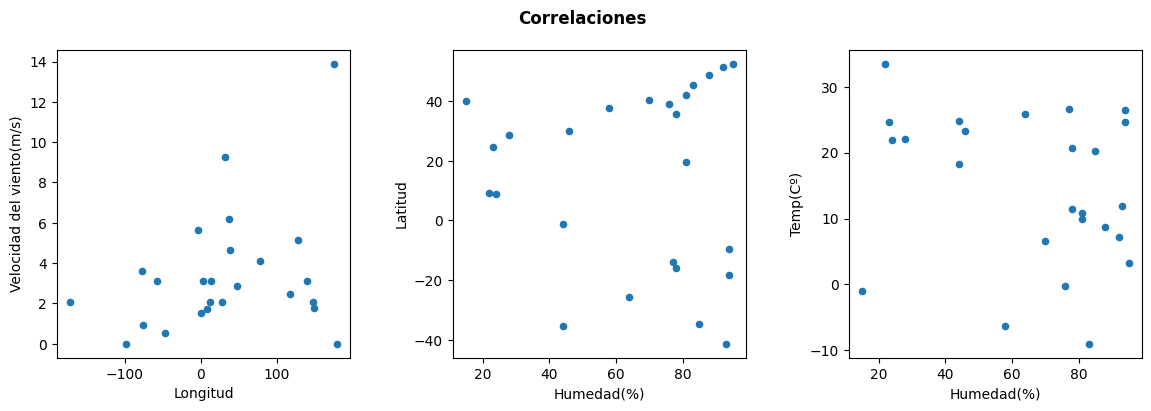

In [20]:
fig,axs = plt.subplots(1,3, figsize=(14,4))
fig.suptitle("Correlaciones", weight="bold")
plt.subplots_adjust(wspace=0.35)
df_tiempo.loc[:,["wind-speed","lon"]].plot.scatter(ax=axs[0], x="lon", y="wind-speed", xlabel="Longitud", ylabel="Velocidad del viento(m/s)")
df_tiempo.loc[:,["main-humidity","lat"]].plot.scatter(ax=axs[1], x="main-humidity", y="lat", xlabel="Humedad(%)", ylabel="Latitud")
df_tiempo.loc[:,["main-temp", "main-humidity"]].plot.scatter(ax=axs[2], x="main-humidity", y="main-temp", xlabel="Humedad(%)", ylabel="Temp(Cº)")

<Axes: xlabel='Cº'>

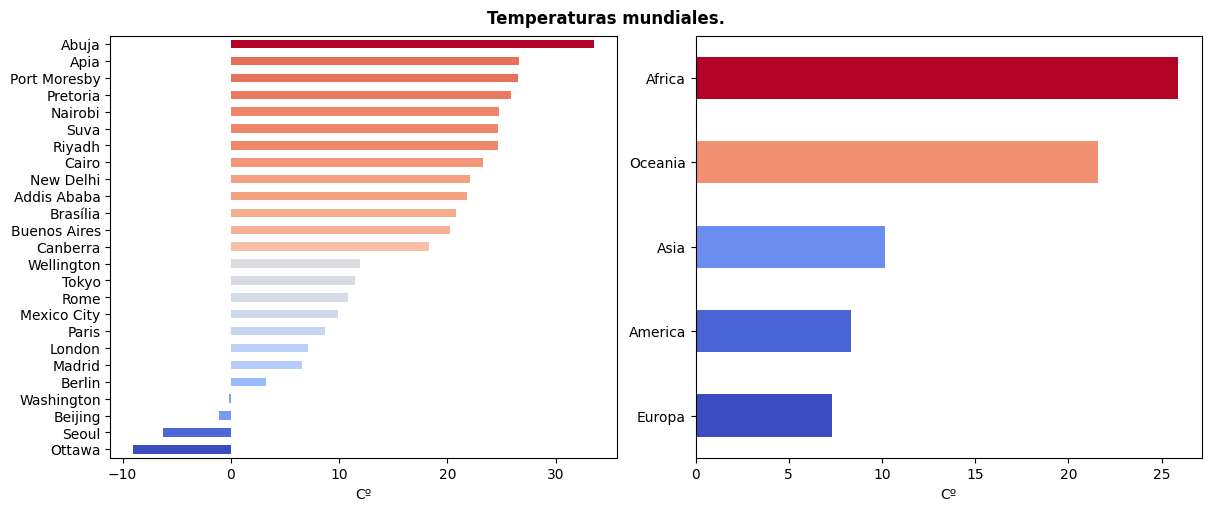

In [21]:
fig,axs = plt.subplots(1,2, figsize=(12, 5), constrained_layout=True)
fig.suptitle("Temperaturas mundiales.", weight="bold")

s_temp=df_tiempo.set_index("name").loc[:,"main-temp"].sort_values()
norm = matplotlib.colors.Normalize(vmin=s_temp.min(), vmax=s_temp.max())
colors = plt.get_cmap("coolwarm")(norm(s_temp.values))
s_temp.plot.barh(ax=axs[0], color=colors, xlabel="Cº", ylabel="")

s_temp=df_tiempo.groupby("continente")["main-temp"].mean().sort_values()
norm = matplotlib.colors.Normalize(vmin=s_temp.min(), vmax=s_temp.max())
colors = plt.get_cmap("coolwarm")(norm(s_temp.values))
s_temp.plot.barh(ax=axs[1], color=colors, xlabel="Cº", ylabel="")

### Summary
Los datos que vemos son los esperados en esta época del año (11 de diciembre), destacar que la mayor correlación de los valores es con la latitud y longitud; siendo poca por ejemplo entre humedad y temperatura. Aunque la valoración de **los datos a nivel global, hace que se difumine la especificidad y la localidad del clima**, la diferencia entre ambos hemisferios es palpable

Por terminar, me he chocado con dos problemas que me han consumido gran cantidad del tiempo. La primera es la dificultad para procesas la repsuesta json y encuadrarla tabularmente en un dataframe, la segunda fue a la hora de generar el mapa de color para el gráfico de barras, el comportamiento de este cuando se usa una Serie o un DataFrame es muy diferente.